### INFO6148 - Natural Language Processing with SpaCy - Project 2   
**Professor:** Dr. Yousefhussien, Mohammed     
**Project:**  Capstone Project - Image Classication with Pytorch     
**Student:** Cassio Azevedo Santanna  
**Student ID:** 1237664

<br>

---

In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import os
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

Move the code to the GPU device if it's available

In [ ]:
# Move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Step 1: Dataset Selection

### Dataset Description: STL-10
The STL-10 dataset is a large image dataset commonly used for unsupervised and semi-supervised learning. It contains 10 classes (`e.g., airplane, bird, car, cat`) with the following characteristics:

- **Training Set:** 5,000 labeled images.
- **Test Set:** 8,000 labeled images.
- **Unlabeled Set:** 100,000 unlabeled images for unsupervised learning.    

Each image is of size 96x96 pixels, making STL-10 a suitable benchmark for evaluating deep learning models in image classification tasks.

In [ ]:
# Define transforms for data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load STL10 dataset
dataset_path = "./data"

train_dataset = datasets.STL10(root=dataset_path, split="train", download=True, transform=transforms.ToTensor())
test_dataset = datasets.STL10(root=dataset_path, split="test", download=True, transform=transforms.ToTensor())

# Create train and validation sets
train_indices, val_indices = train_test_split(
    range(len(train_dataset)), test_size=0.2, random_state=42  # Adjust random_state as needed
)

train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=4)

print("STL10 dataset loaded successfully!")

100%|██████████| 2.64G/2.64G [01:03<00:00, 41.3MB/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified
STL10 dataset loaded successfully!


The code is dedicated to preprocessing and loading the STL-10 dataset to be further used in the pipeline.

- **Preprocessed Data:** The dataset is normalized and prepared as PyTorch tensors, ready for model training and evaluation.

- **Efficient Data Handling:** The DataLoader objects facilitate efficient data batching, shuffling, and parallel loading, optimizing the training process.

- **Improved Model Generalization:** The train-validation split allows for reliable evaluation and hyperparameter tuning, improving the model's ability to generalize to unseen data.

In [ ]:
image, label = train_dataset[0]
print(f"Image shape: {image.shape}") # Image Shape
print(f"Number of classes: {len(train_dataset.classes)}") # Number of classes
print(f"Classes: {train_dataset.classes}") # Classes

Image shape: torch.Size([3, 96, 96])
Number of classes: 10
Classes: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [ ]:
# Define number of classes and subset selection
num_classes = len(train_dataset.classes)  # STL10 has 10 classes
max_images_per_class = 1000
print(f"Dataset has {num_classes} classes: {train_dataset.classes}")

# Prepare balanced subset
subset_indices = []
class_count = {cls: 0 for cls in range(num_classes)}
for idx in range(len(train_dataset)):
    label = train_dataset[idx][1]
    if class_count[label] < max_images_per_class:
        subset_indices.append(idx)
        class_count[label] += 1

print(f"Selected {len(subset_indices)} images for training (up to {max_images_per_class} per class).")


Dataset has 10 classes: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
Selected 5000 images for training (up to 1000 per class).


<h3>Dataset samples visualization</h3>   

This code visualize 10 random images from the dataset along with their corresponding class labels.     
This visualization step helps in exploring the dataset, ensuring data integrity, and understanding the distribution of images and their labels before training the model.

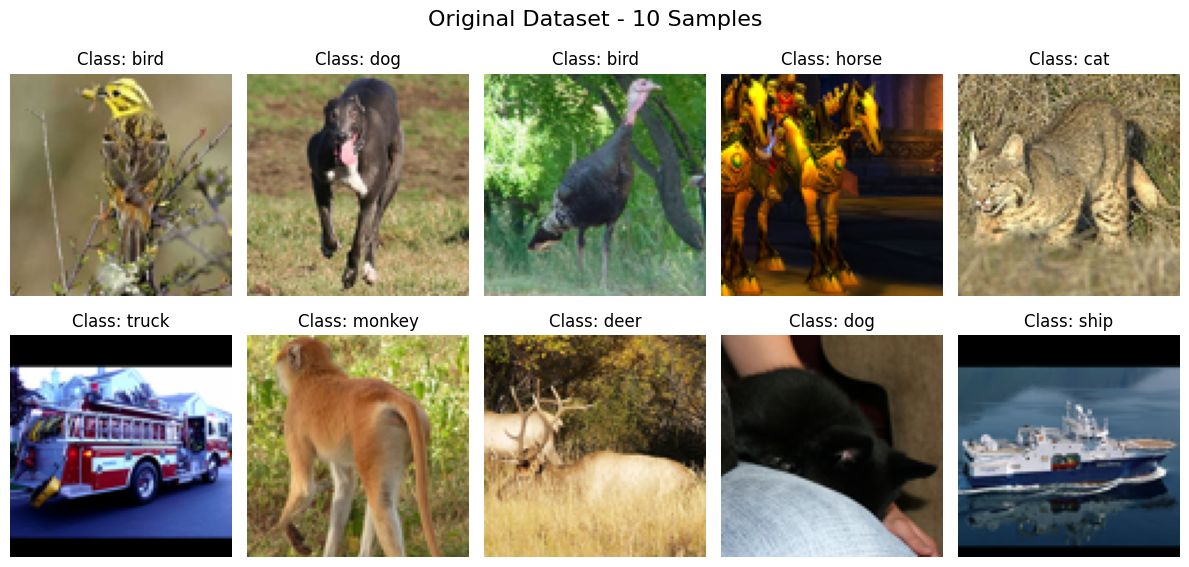

In [ ]:
# Visualize 10 random images from the dataset
def visualize_images(dataset, indices, title):
    """Function to visualize a subset of images from the dataset."""
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        if i < len(indices):
            image, label = dataset[indices[i]]
            # transpose image
            ax.imshow(image.numpy().transpose(1, 2, 0))
            # Using the label to find the the classes name
            ax.set_title(f"Class: {dataset.classes[label]}", fontsize=12)
            ax.axis('off')
        else:
            ax.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_images(train_dataset, subset_indices[:10], "Original Dataset - 10 Samples")



<h3>Data Preprocessing and Augmentation</h3>     

A data augmentation pipeline is created for the training dataset to increase the model's generalization capability by introducing some variations in the input images.    

The preprocessing step aims at increasing data diversity through augmentation, reducing overfitting, and improving the generalization of the model to new, unseen data by simulating real-world variations in input images.     

**Augmentation type**    
- **Structural transforms**
 - `transforms.RandomHorizontalFlip(p=0.3)`: Reduce the probability to 30%
 - `transforms.RandomResizedCrop(96, scale=(0.8, 1.0))`: Increase the crop range, closer to the original
 - `transforms.RandomRotation(5)`: Reduce rotation to 5 degrees

- **Visual transforms**
  - `transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),`: Lower the impact on color modifications
  - `transforms.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 1))`: Smaller kernel and reduced sigma for softer blurring

- **Final conversion**
  - `transforms.ToTensor()`: Convert the image to a tensor
  - `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`: Normalize the tensor using specified mean and std


In [ ]:
# Data Preprocessing and Augmentation
train_transform = transforms.Compose([
    # Structural transforms
    transforms.RandomHorizontalFlip(), # p=0.3
    transforms.RandomResizedCrop(96, scale=(0.8, 1.0)),
    transforms.RandomRotation(10),

    # Visual transforms
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 1)),

    # Final conversion
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Apply transformations to the training dataset
train_dataset.transform = train_transform


<h3>Denormalize images</h3>

The code aims to enable the visual inspection of preprocessed images by converting them from the normalized format when training back to human-readable format. It guarantees that the images are displayed correctly with their original colors and intensities of the pixels.


**Challenges:**
- Managing different normalization and denormalization schemes across datasets can be complex, requiring careful adjustments to ensure pixel integrity.
- Ensuring that the denormalized image remains within valid display ranges `(0 to 1)` without clipping relevant details.

In [ ]:
# Denormalize images
def denormalize(tensor, mean, std):
    """Reverts image normalization."""
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Revert normalization
    return tensor

mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

# Visualize normalized images in the dataset
image, label = train_dataset[0]  # Retrieve an image from the dataset
image = denormalize(image.clone(), mean, std)  # Denormalize
image = image.permute(1, 2, 0).numpy()  # Rearrange dimensions to [H, W, C]

# Ensure values are in the range [0, 1] for display
image = np.clip(image, 0, 1)

<h1>Visualizing Augmented Images</h1>

The code aims to display preprocessed and transformed augmented images to show how the dataset is being transformed during training. This helps make sure that the augmentation process is working as expected and gives a visual confirmation of what data is being fed into the model.

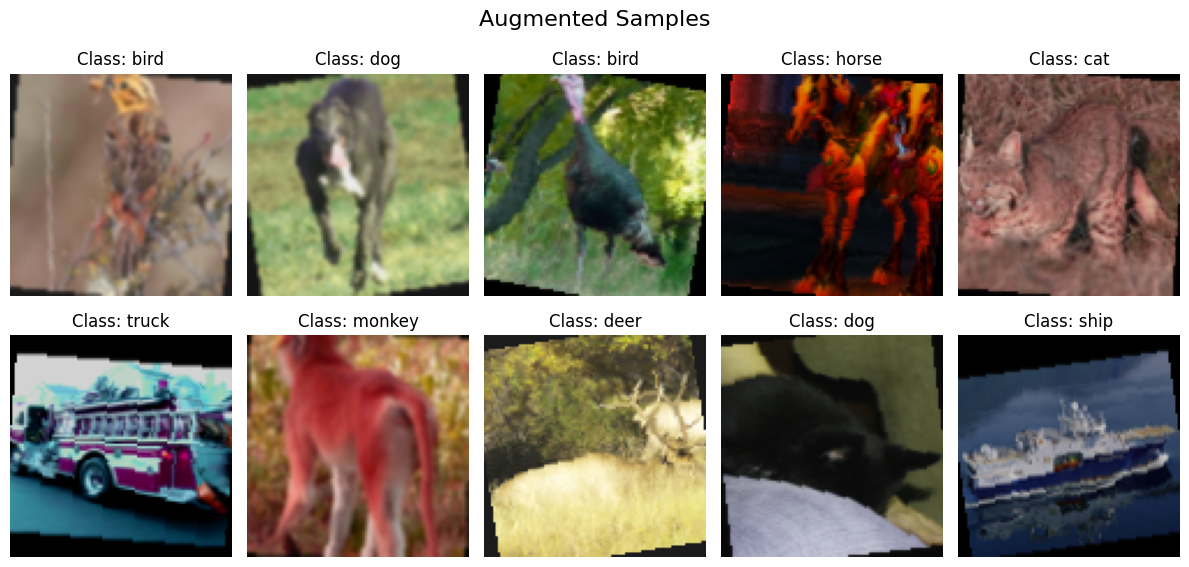

In [ ]:
# Display classes with applied augmentations
def visualize_augmented_images(dataset, num_samples=num_classes):
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]
    nrows = 2
    ncols = 5

    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 6))
    axes = axes.flatten()

    for i in range(num_samples):
        image, label = dataset[i]  # Retrieve an image from the dataset with augmentation
        image = denormalize(image.clone(), mean, std)  # Denormalize for display
        image = image.permute(1, 2, 0).numpy()  # Adjust dimensions for Matplotlib
        image = np.clip(image, 0, 1)  # Ensure values are in the range [0, 1]

        axes[i].imshow(image)
        axes[i].set_title(f"Class: {dataset.classes[label]}")
        axes[i].axis('off')
    plt.suptitle("Augmented Samples", fontsize=16)
    plt.tight_layout()
    plt.show()

# Display 10 images with augmentation
visualize_augmented_images(train_dataset)


**Result:**    
This function provides a visual representation of the augmented images, helping to verify that the applied augmentations (like `rotation, flipping, and color jittering`) are correctly applied and that the model will be trained on appropriately modified data.

<h1>Model Definition with Dropout Regularization</h1>

The code aims to define a simple CNN model using dropout regularization for classification of images from the dataset. This could help avoid over-fitting by randomly turning off a fraction of neurons during training; hence, the model generalizes well.

<h3>Challenges:</h3>

- **Choosing Dropout Rate:** Selecting an appropriate dropout rate (50% in this case) can be tricky, as too high a dropout rate may hinder learning, while too low may not effectively prevent overfitting.
- **Model Complexity:** Designing a simple CNN that balances performance with computational efficiency is important. The added dropout layers introduce complexity, requiring fine-tuning for optimal results.

In [ ]:
# Model Definition
# CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 24 * 24, 128)
        self.fc2 = nn.Linear(128, num_classes)

        # Dropout layers for regularization
        self.dropout1 = nn.Dropout(0.5)  # 50% dropout on fc1
        self.dropout2 = nn.Dropout(0.5)  # 50% dropout on fc2

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)  # Apply dropout
        x = self.fc2(x)
        x = self.dropout2(x)  # Apply dropout
        return x

# ResNet18
def get_resnet18(num_classes):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

<h1>Model Training</h1>

The the code aims to train the model on the training dataset, iterating through it the number of times specified in the range, based on the number of epochs. In the process, it keeps count of the performance of the model regarding loss and accuracy and updates at each epoch for tracking and observing the improvement of the model over time.

<h3>Challenges:</h3>

- **Overfitting and Underfitting:** If the model overfits or underfits the data, adjustments to hyperparameters, data augmentation, or regularization (like dropout) may be required.
- **Device Management:** Ensuring that both the model and data are correctly moved to the device (CPU or GPU) is crucial for efficient training.
- **Efficiency of Training:** Training large models on large datasets can be time-consuming, and optimizations such as using GPU acceleration or adjusting batch sizes might be necessary to speed up the process.


In [ ]:
# # Model Training
# # Trains the model, monitors the loss and accuracy, and displays the progress after each epoch.

# Implementation of training with Early Stopping
def train_model(model, train_loader, val_loader, optimizer, loss_function, device, epochs, patience=4):
    model.train()  # Training mode
    train_loss, train_acc = [], []  # List of training losses and accuracies
    best_val_loss = float('inf')  # Initialize with a very high value
    patience_counter = 0  # Counter for early stopping

    print(f"\n----- Training {model.__class__.__name__} -----\n")

    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0.0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        epoch_loss = total_loss / len(train_loader)
        epoch_acc = correct / len(train_loader.dataset)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        # Validation
        val_loss = validate_model(model, val_loader, loss_function, device)
        print(f"Epoch [{epoch + 1}/{epochs}] .... Train Loss: {epoch_loss:.4f} .... Train Accuracy: {epoch_acc:.2f}% .... Val Loss: {val_loss:.4f}")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset the counter
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered. Stopping training.")
                break

    print("Training complete!")
    return train_loss, train_acc

# Validation function to calculate the loss on the validation set
def validate_model(model, val_loader, loss_function, device):
    model.eval()  # Evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(val_loader)


<h1>Hyperparameter Tuning </h1>

The code aims to find an optimum learning rate, batch size, and optimizers to train the model. Based on the obtained values of both parameters, different experiments were run to explore which outperforms. Generally, lower loss together with higher accuracy reflects better results in models performance.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_function = nn.CrossEntropyLoss()
epochs = 40
#Hyperparameters
learning_rates = [0.0001, 0.00001]
batch_sizes = [128, 256]
optimizers = {'Adam': optim.Adam, 'RMSprop': optim.RMSprop}

In [ ]:
## Hyperparameter Tuning
for model_name in ["SimpleCNN", "ResNet18"]:
    if model_name == "SimpleCNN":
        model = SimpleCNN(num_classes=len(train_dataset.classes)).to(device)
    elif model_name == "ResNet18":
        model = get_resnet18(num_classes=len(train_dataset.classes)).to(device)

    for opt_name, optimizer_class in optimizers.items():
        for lr in learning_rates:
            for batch_size in batch_sizes:
                optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay=1e-5)

                print(f"\nTraining {model_name} with Optimizer: {opt_name}, LR: {lr}, Batch Size: {batch_size}")
                train_loss, train_acc = train_model(
                    model, train_loader, val_loader, optimizer, loss_function, device, epochs
                )


Training SimpleCNN with Optimizer: Adam, LR: 0.0001, Batch Size: 128

----- Training SimpleCNN -----

Epoch [1/40] .... Train Loss: 2.2769 .... Train Accuracy: 0.14% .... Val Loss: 2.1817
Epoch [2/40] .... Train Loss: 2.1954 .... Train Accuracy: 0.19% .... Val Loss: 2.0905
Epoch [3/40] .... Train Loss: 2.1597 .... Train Accuracy: 0.21% .... Val Loss: 2.0399
Epoch [4/40] .... Train Loss: 2.1285 .... Train Accuracy: 0.23% .... Val Loss: 1.9967
Epoch [5/40] .... Train Loss: 2.1041 .... Train Accuracy: 0.24% .... Val Loss: 1.9487
Epoch [6/40] .... Train Loss: 2.0853 .... Train Accuracy: 0.24% .... Val Loss: 1.9404
Epoch [7/40] .... Train Loss: 2.0679 .... Train Accuracy: 0.26% .... Val Loss: 1.9058
Epoch [8/40] .... Train Loss: 2.0477 .... Train Accuracy: 0.25% .... Val Loss: 1.8737
Epoch [9/40] .... Train Loss: 2.0398 .... Train Accuracy: 0.26% .... Val Loss: 1.8441
Epoch [10/40] .... Train Loss: 2.0100 .... Train Accuracy: 0.27% .... Val Loss: 1.8524
Epoch [11/40] .... Train Loss: 2.003

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s]



Training ResNet18 with Optimizer: Adam, LR: 0.0001, Batch Size: 128

----- Training ResNet -----

Epoch [1/40] .... Train Loss: 1.2149 .... Train Accuracy: 0.59% .... Val Loss: 0.5494
Epoch [2/40] .... Train Loss: 0.5269 .... Train Accuracy: 0.83% .... Val Loss: 0.3723
Epoch [3/40] .... Train Loss: 0.3772 .... Train Accuracy: 0.87% .... Val Loss: 0.2924
Epoch [4/40] .... Train Loss: 0.2744 .... Train Accuracy: 0.90% .... Val Loss: 0.2057
Epoch [5/40] .... Train Loss: 0.2206 .... Train Accuracy: 0.94% .... Val Loss: 0.1568
Epoch [6/40] .... Train Loss: 0.1830 .... Train Accuracy: 0.94% .... Val Loss: 0.1410
Epoch [7/40] .... Train Loss: 0.1436 .... Train Accuracy: 0.96% .... Val Loss: 0.1063
Epoch [8/40] .... Train Loss: 0.1222 .... Train Accuracy: 0.96% .... Val Loss: 0.1072
Epoch [9/40] .... Train Loss: 0.1061 .... Train Accuracy: 0.97% .... Val Loss: 0.0761
Epoch [10/40] .... Train Loss: 0.0956 .... Train Accuracy: 0.97% .... Val Loss: 0.0746
Epoch [11/40] .... Train Loss: 0.1286 ..

## Model Evaluation
The code focuses on the validation dataset to see whether the model is performing well by making the right predictions. It figures out the important metrics of precision, recall, and the F1-score, and also shows how the model is performing by including a confusion matrix to put everything in a clear light.


Classification Report:
              precision    recall  f1-score   support

    airplane       1.00      1.00      1.00        93
        bird       1.00      1.00      1.00        89
         car       1.00      1.00      1.00       114
         cat       1.00      1.00      1.00        91
        deer       1.00      1.00      1.00        95
         dog       0.99      1.00      1.00       114
       horse       1.00      0.99      0.99       100
      monkey       1.00      1.00      1.00       101
        ship       1.00      0.99      1.00       107
       truck       0.99      1.00      0.99        96

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



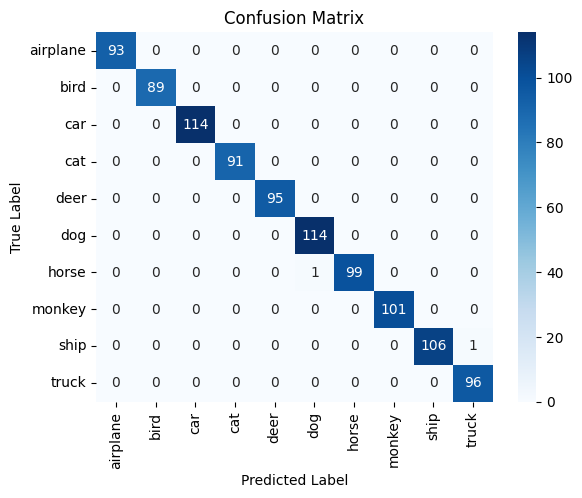

In [ ]:
# Model Evaluation
# Evaluates the model and calculates metrics such as precision, recall, and F1-score.
def evaluate_model(model, val_loader, device):
    model.eval()  # evaluation mode
    all_preds, all_labels = [], []  # Lists to store predictions and true labels

    with torch.no_grad():  # Disables gradient calculation for inference
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)   # Forward pass: model predictions
            preds = outputs.argmax(1)  # Get the predicted class for each sample
            all_preds.extend(preds.cpu().numpy())    # Store predictions in a list
            all_labels.extend(labels.cpu().numpy())  # Store true labels in a list

    # Classification report and confusion matrix
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

# Model evaluation
evaluate_model(model, val_loader, device)


<h1>Final Model Testing</h1>

The code aims to evaluates the final performance of the model on the test set, calculating its accuracy. The test accuracy will be a final measure of the model's ability to generalize to new, unseen data, using a separate test set that wasn't involved in training or validation.

<h3>Challenges: </h3>

 - **Overfitting:** If the model was overfitted to the training or validation set, the test accuracy might be misleadingly high, failing to represent its performance on real-world, unseen data.
 - **Imbalanced Test Set:** If the test set is imbalanced, accuracy alone may not reflect the model's true performance, especially if it predicts the majority class correctly but fails on others.
 - **Computational Resources:** Large test datasets can still require considerable computational resources, especially if the model is complex or the test set is large.

In [ ]:
# Final Model Testing
def test_model(model, test_loader, device):
    """Avalia o modelo final no conjunto de teste e exibe a precisão."""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total * 100
    print(f"Final Test Accuracy: {accuracy:.2f}%")

# Teste final do modelo
test_model(model, test_loader, device)


Final Test Accuracy: 80.81%


In [ ]:
#THE END

# Research Sources
- **INFO6147 Deep Learning with Pytorch** - In Class Materials from Module 1 to Module 11
- **Pytorch Documentation and Examples** - https://pytorch.org/tutorials/recipes/recipes_index.html
- **Pytorch Learn wiht examples** - https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
- **GeeksforGeeks** - https://www.geeksforgeeks.org/resnet18-from-scratch-using-pytorch/
- **Medium** - https://medium.com/@myringoleMLGOD/simple-convolutional-neural-network-cnn-for-dummies-in-pytorch-a-step-by-step-guide-6f4109f6df80